# SRH and GBV post like Analysis using IV and WOE

The goal of this analysis is to explore factors that influence the likablity of a post.

In [1]:
import json
import pandas as pd
from pandas.api.types import is_numeric_dtype

from Features import *
from AttributeRelevance import *

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

## Data Overview

In [3]:
# load the processed fb posts data
df = pd.read_csv('data/cleaned_fb_posts.csv', na_values=[' '], index_col=0)

# load the keywords
f = open('data/keywords.json')
keywords = json.load(f)
keyword_list = []
for list_ in keywords.values():
    keyword_list.extend(list_)

# Transform each element of a list-like to a row, replicating index values.
df['keyword'] = df['keyword'].apply(lambda x: x.split(','))
df = df.explode('keyword').reset_index()
df = df.drop(columns='index')
df.head(5)

,Text,keyword,label
0,"""Unmet need for #contraception was 34% for the...",Contraception,0
1,The handbook challenges readers to consider #m...,Sexual health,0
2,The handbook challenges readers to consider #m...,sex,0
3,The handbook challenges readers to consider #m...,challenges,0
4,"""In #Tanzania, 21.7% of women desire to delay ...",Contraception,0


In [4]:
feats_dict = {}

for col in [c for c in df.columns if (c != 'label' and c != 'Text')]:
    if is_numeric_dtype(df[col]):
        feats_dict[col] = ContinuousFeature(df, col)
    else:
        feats_dict[col] = CategoricalFeature(df, col)

feats = list(feats_dict.values())

## Information Value and Weight of Evidence

Attribute relevance analysis evaluates attribute values' impact on target variable. It helps in recognizing the most important variables which have the greatest impact on target variable and understanding relations and logic between the most important predictors and the target variable.

Information value (IV) and weight of evidence (WOE) are simple and powerful techniques of conducting attribute relevance analysis. They provide a great framework for exploratory analysis and have been used extensively in the credit risk world for several decades.

**Information value**
>IV measures the strength of a relationship.

>Information Value provides a measure of how well a variable X is able to distinguish between a binary response (e.g. "good" versus "bad") in some target variable Y. The idea is if a variable X has a low Information Value, it may not do a sufficient job of classifying the target variable, and hence is removed as an explanatory variable.

**Weight of evidence**
>WOE describes the relationship between a predictive variable and a binary target variable.

>The weight of evidence tells the predictive power of an independent variable in relation to the dependent variable. Since it evolved from credit scoring world, it is generally described as a measure of the separation of good and bad customers. "Bad Customers" refers to the customers who defaulted on a loan. and "Good Customers" refers to the customers who paid back loan.

**IV values interpretation**

| Information value        | Predictive power           |
| ------------- |:-------------:|
| < 0.02      | useless for prediction |
| 0.02 - 0.1      | weak predictor      |
| 0.1 - 0.3 | medium predictor      |
| 0.3 - 0.5 | strong predictor      |
| > 0.5 | suspicious or too good      |

In [5]:
iv = IV()
ar = AttributeRelevance()

In [6]:
feats_dict['keyword'].df_lite

,bin,label
0,Contraception,0
1,Sexual health,0
2,sex,0
3,challenges,0
4,Contraception,0
...,...,...
384,Gender-based violence,1
385,rape,1
386,sex,1
387,awareness,1


In [7]:
df, df_sum = iv.calculate_iv(feats_dict['keyword'])
print(df.head())
print("iv sum: ", df_sum)

         keyword  count  good  bad  perc_good  perc_bad  perc_diff   woe    iv
0       Abortion     26     3   23       0.03      0.08      -0.04 -0.79  0.03
1     Adolescent      2     0    2       0.00      0.01      -0.01  0.00 -0.00
2       Barriers      2     0    2       0.00      0.01      -0.01  0.00 -0.00
3  Contraception     25     0   25       0.00      0.08      -0.08  0.00 -0.00
4       Facebook      8     2    6       0.02      0.02       0.00  0.15  0.00
iv sum:  0.6944098239135205


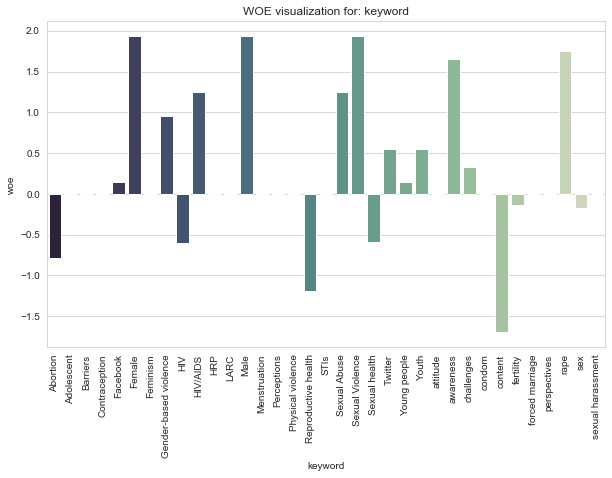

In [8]:
iv.visualize(feats_dict['keyword'], 'woe')

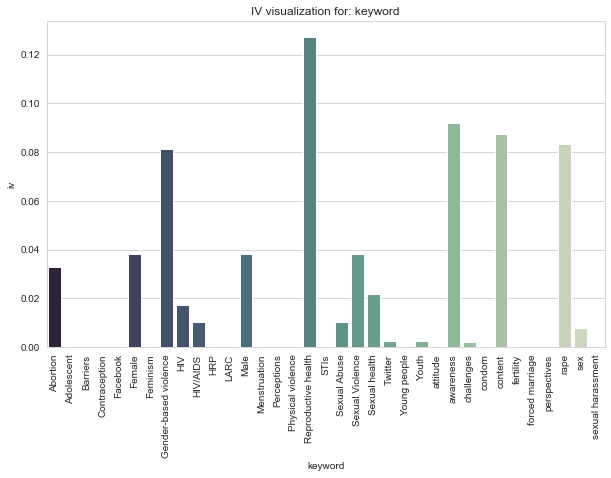

In [9]:
iv.visualize(feats_dict['keyword'], 'iv')

In [10]:
ar.analyze(feats, iv, interpretation=True)

,iv,iv_interpretation
keyword,0.69,suspicious


In [11]:
# save the woe and iv of the data
df = df[['keyword', 'woe', 'iv']]
df.to_csv('data/woe_iv_data.csv')